In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0604/weights_KD_segformer_0604_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 1
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 6.9770e-05

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 540ms/step - loss: 3.5104e-05
Average validation loss: 0.6127886176109314
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 554ms/step - loss: 3.5104e-05 - val_loss: 0.6128
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 649ms/step - loss: 2.5476e-05 - val_loss: 0.6128
Average validation loss: 0.7124459147453308
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 670ms/step - loss: 2.5476e-05 - val_loss: 0.6626
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 789ms/step - loss: 2.0708e-05 - val_loss: 0.6626
Average validation loss: 0.6474623680114746
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 802ms/step - loss: 2.0708e-05 - val_loss: 0.6576
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 797ms/step - loss: 1.7596e-05 - val_loss: 0.6576
Average validation loss: 0.36945486068725586
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 810ms/step - loss: 1.7596e-05 - val_loss: 0.5855
Saved model weights to 'c:\天_11157

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 776ms/step - loss: 1.7747e-06
Average validation loss: 0.2709072679281235
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 787ms/step - loss: 1.7747e-06 - val_loss: 0.2709
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 828ms/step - loss: 1.6811e-06 - val_loss: 0.2709
Average validation loss: 0.2378852590918541
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 838ms/step - loss: 1.6811e-06 - val_loss: 0.2544
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_10.pth'.
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 766ms/step - loss: 1.6376e-06 - val_loss: 0.2544
Average validation loss: 0.16651617735624313
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 779ms/step - loss: 1.6376e-06 - val_loss: 0.2251
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_K

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 770ms/step - loss: 1.4723e-06
Average validation loss: 0.12122168391942978
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 780ms/step - loss: 1.4723e-06 - val_loss: 0.1212
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 785ms/step - loss: 1.3114e-06 - val_loss: 0.1212
Average validation loss: 0.07485866049925487
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 796ms/step - loss: 1.3114e-06 - val_loss: 0.0980
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_15.pth'.
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 776ms/step - loss: 1.2653e-06 - val_loss: 0.0980
Average validation loss: 0.12310367574294408
12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 789ms/step - loss: 1.2653e-06 - val_loss: 0.1064
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 38s 774ms/step - loss: 1.2249e

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 840ms/step - loss: 5.1706e-07
Average validation loss: 0.014349481440149248
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 851ms/step - loss: 5.1706e-07 - val_loss: 0.0143
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 815ms/step - loss: 4.6551e-07 - val_loss: 0.0143
Average validation loss: 0.03782824182417244
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 826ms/step - loss: 4.6551e-07 - val_loss: 0.0261
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 808ms/step - loss: 4.2604e-07 - val_loss: 0.0261
Average validation loss: 0.024814882315695286
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 819ms/step - loss: 4.2604e-07 - val_loss: 0.0257
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 53s 810ms/step - loss: 3.9530e-07 - val_loss: 0.0257
Average validation loss: 0.025447927182540298
16/16 ━━━━━━━━━━━━━━━━━━━━ 53s 821ms/step - loss: 3.9530e-07 - val_loss: 0.0256
Epoch

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 776ms/step - loss: 2.3886e-07
Average validation loss: 0.015400195959955454
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 790ms/step - loss: 2.3886e-07 - val_loss: 0.0154
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 754ms/step - loss: 2.2374e-07 - val_loss: 0.0154
Average validation loss: 0.014781248662620783
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 767ms/step - loss: 2.2374e-07 - val_loss: 0.0151
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_25.pth'.
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 46s 758ms/step - loss: 2.1927e-07 - val_loss: 0.0151
Average validation loss: 0.01653867745772004
20/20 ━━━━━━━━━━━━━━━━━━━━ 47s 771ms/step - loss: 2.1927e-07 - val_loss: 0.0156
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 62s 756ms/step - loss: 2.1

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 793ms/step - loss: 2.2325e-07
Average validation loss: 0.00648263036661471
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 807ms/step - loss: 2.2325e-07 - val_loss: 0.0065
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 783ms/step - loss: 2.0190e-07 - val_loss: 0.0065
Average validation loss: 0.008497201944313323
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 795ms/step - loss: 2.0190e-07 - val_loss: 0.0075
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 57s 774ms/step - loss: 1.8128e-07 - val_loss: 0.0075
Average validation loss: 0.01101881371384176
24/24 ━━━━━━━━━━━━━━━━━━━━ 57s 787ms/step - loss: 1.8128e-07 - val_loss: 0.0087
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 76s 773ms/step - loss: 1.7346e-07 - val_loss: 0.0087
Average validation loss: 0.011146129186575612
24/24 ━━━━━━━━━━━━━━━━━━━━ 76s 786ms/step - loss: 1.7346e-07 - val_loss: 0.0093
Epoch 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 788ms/step - loss: 5.5523e-07
Average validation loss: 0.02281020092777908
40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 801ms/step - loss: 5.5523e-07 - val_loss: 0.0228
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 790ms/step - loss: 4.5966e-07 - val_loss: 0.0228
Average validation loss: 0.03333695799810812
40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 803ms/step - loss: 4.5966e-07 - val_loss: 0.0281
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 95s 783ms/step - loss: 4.0603e-07 - val_loss: 0.0281
Average validation loss: 0.03318388964980841
40/40 ━━━━━━━━━━━━━━━━━━━━ 96s 796ms/step - loss: 4.0603e-07 - val_loss: 0.0298
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 127s 779ms/step - loss: 3.6442e-07 - val_loss: 0.0298
Average validation loss: 0.03281212731380947
40/40 ━━━━━━━━━━━━━━━━━━━━ 128s 792ms/step - loss: 3.6442e-07 - val_loss: 0.0305
Epoch 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 789ms/step - loss: 2.5466e-07
Average validation loss: 0.013760765684613338
48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 801ms/step - loss: 2.5466e-07 - val_loss: 0.0138
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 78s 817ms/step - loss: 2.2359e-07 - val_loss: 0.0138
Average validation loss: 0.020243423108089093
48/48 ━━━━━━━━━━━━━━━━━━━━ 78s 829ms/step - loss: 2.2359e-07 - val_loss: 0.0170
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 119s 853ms/step - loss: 1.9168e-07 - val_loss: 0.0170
Average validation loss: 0.014351291455871737
48/48 ━━━━━━━━━━━━━━━━━━━━ 120s 864ms/step - loss: 1.9168e-07 - val_loss: 0.0161
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 159s 823ms/step - loss: 1.7061e-07 - val_loss: 0.0161
Average validation loss: 0.012062979459490938
48/48 ━━━━━━━━━━━━━━━━━━━━ 160s 835ms/step - loss: 1.7061e-07 - val_loss: 0.0151


c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 44s 782ms/step - loss: 1.1130e-07
Average validation loss: 0.019116080831736326
56/56 ━━━━━━━━━━━━━━━━━━━━ 44s 794ms/step - loss: 1.1130e-07 - val_loss: 0.0191
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 88s 786ms/step - loss: 1.0015e-07 - val_loss: 0.0191
Average validation loss: 0.02707952876309199
56/56 ━━━━━━━━━━━━━━━━━━━━ 89s 797ms/step - loss: 1.0015e-07 - val_loss: 0.0231
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 134s 793ms/step - loss: 8.9778e-08 - val_loss: 0.0231
Average validation loss: 0.021545904921367764
56/56 ━━━━━━━━━━━━━━━━━━━━ 134s 805ms/step - loss: 8.9778e-08 - val_loss: 0.0226
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 179s 798ms/step - loss: 8.0818e-08 - val_loss: 0.0226
Average validation loss: 0.027351232478395104
56/56 ━━━━━━━━━━━━━━━━━━━━ 179s 809ms/step - loss: 8.0818e-08 - val_loss: 0.0238
E

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 50s 779ms/step - loss: 1.5615e-07
Average validation loss: 0.027392871445044875
64/64 ━━━━━━━━━━━━━━━━━━━━ 51s 790ms/step - loss: 1.5615e-07 - val_loss: 0.0274
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 100s 776ms/step - loss: 1.3850e-07 - val_loss: 0.0274
Average validation loss: 0.023532809631433338
64/64 ━━━━━━━━━━━━━━━━━━━━ 101s 788ms/step - loss: 1.3850e-07 - val_loss: 0.0255
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_80.pth'.
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 151s 782ms/step - loss: 1.2778e-07 - val_loss: 0.0255
Average validation loss: 0.026476921018911526
64/64 ━━━━━━━━━━━━━━━━━━━━ 152s 793ms/step - loss: 1.2778e-07 - val_loss: 0.0258
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 202s 777ms/step - los

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 778ms/step - loss: 8.0499e-08
Average validation loss: 0.021363627501866884
72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 789ms/step - loss: 8.0499e-08 - val_loss: 0.0214
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 113s 782ms/step - loss: 6.5055e-08 - val_loss: 0.0214
Average validation loss: 0.022721111570717767
72/72 ━━━━━━━━━━━━━━━━━━━━ 114s 792ms/step - loss: 6.5055e-08 - val_loss: 0.0220
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 170s 782ms/step - loss: 5.5961e-08 - val_loss: 0.0220
Average validation loss: 0.021824857181248564
72/72 ━━━━━━━━━━━━━━━━━━━━ 171s 793ms/step - loss: 5.5961e-08 - val_loss: 0.0220
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 227s 779ms/step - loss: 5.0735e-08 - val_loss: 0.0220
Average validation loss: 0.022660773066389892
72/72 ━━━━━━━━━━━━━━━━━━━━ 228s 790ms/step - loss: 5.0735e-08 - val_loss: 0.022

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 788ms/step - loss: 8.7033e-08
Average validation loss: 0.017771116481162606
80/80 ━━━━━━━━━━━━━━━━━━━━ 64s 798ms/step - loss: 8.7033e-08 - val_loss: 0.0178
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 136s 898ms/step - loss: 7.1608e-08 - val_loss: 0.0178
Average validation loss: 0.014922571391798556
80/80 ━━━━━━━━━━━━━━━━━━━━ 137s 909ms/step - loss: 7.1608e-08 - val_loss: 0.0163
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_100.pth'.
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 204s 843ms/step - loss: 6.1401e-08 - val_loss: 0.0163
Average validation loss: 0.01836556099005975
80/80 ━━━━━━━━━━━━━━━━━━━━ 205s 853ms/step - loss: 6.1401e-08 - val_loss: 0.0170
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 270s 812ms/step - lo

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 77s 803ms/step - loss: 1.1968e-07
Average validation loss: 0.021718717927190784
96/96 ━━━━━━━━━━━━━━━━━━━━ 78s 814ms/step - loss: 1.1968e-07 - val_loss: 0.0217
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 153s 779ms/step - loss: 9.8107e-08 - val_loss: 0.0217
Average validation loss: 0.0250318037190785
96/96 ━━━━━━━━━━━━━━━━━━━━ 154s 790ms/step - loss: 9.8107e-08 - val_loss: 0.0234
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 227s 761ms/step - loss: 8.3631e-08 - val_loss: 0.0234
Average validation loss: 0.025322918362993125
96/96 ━━━━━━━━━━━━━━━━━━━━ 228s 773ms/step - loss: 8.3631e-08 - val_loss: 0.0240
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 303s 782ms/step - loss: 7.1902e-08 - val_loss: 0.0240
Average validation loss: 0.02759265115795036
96/96 ━━━━━━━━━━━━━━━━━━━━ 304s 793ms/step - loss: 7.1902e-08 - val_loss: 0.0249


c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 100s 835ms/step - loss: 2.2230e-07
Average validation loss: 0.021472967974841595
120/120 ━━━━━━━━━━━━━━━━━━━━ 101s 846ms/step - loss: 2.2230e-07 - val_loss: 0.0215
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 198s 804ms/step - loss: 2.5242e-07 - val_loss: 0.0215
Average validation loss: 0.021682655974291264
120/120 ━━━━━━━━━━━━━━━━━━━━ 199s 815ms/step - loss: 2.5242e-07 - val_loss: 0.0216
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 294s 788ms/step - loss: 2.1177e-07 - val_loss: 0.0216
Average validation loss: 0.020293731770167748
120/120 ━━━━━━━━━━━━━━━━━━━━ 295s 799ms/step - loss: 2.1177e-07 - val_loss: 0.0211
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_150.pth'.
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 392

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 112s 776ms/step - loss: 1.6987e-07
Average validation loss: 0.017183992744927917
144/144 ━━━━━━━━━━━━━━━━━━━━ 113s 787ms/step - loss: 1.6987e-07 - val_loss: 0.0172
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 227s 789ms/step - loss: 1.4243e-07 - val_loss: 0.0172
Average validation loss: 0.01858524814532656
144/144 ━━━━━━━━━━━━━━━━━━━━ 228s 799ms/step - loss: 1.4243e-07 - val_loss: 0.0179
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 340s 777ms/step - loss: 1.2351e-07 - val_loss: 0.0179
Average validation loss: 0.01820350205525756
144/144 ━━━━━━━━━━━━━━━━━━━━ 342s 788ms/step - loss: 1.2351e-07 - val_loss: 0.0180
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 454s 778ms/step - loss: 1.1266e-07 - val_loss: 0.0180
Average validation loss: 0.018404179323826812
144/144 ━━━━━━━━━━━━━━━━━━━━ 456s 789ms/step - loss: 1.1266e-07 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 124s 775ms/step - loss: 1.1532e-07
Average validation loss: 0.017425630084471778
160/160 ━━━━━━━━━━━━━━━━━━━━ 126s 787ms/step - loss: 1.1532e-07 - val_loss: 0.0174
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 252s 786ms/step - loss: 9.0765e-08 - val_loss: 0.0174
Average validation loss: 0.01289436816587113
160/160 ━━━━━━━━━━━━━━━━━━━━ 254s 797ms/step - loss: 9.0765e-08 - val_loss: 0.0152
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_200.pth'.
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 379s 782ms/step - loss: 7.6295e-08 - val_loss: 0.0152
Average validation loss: 0.01826618232880719
160/160 ━━━━━━━━━━━━━━━━━━━━ 380s 793ms/step - loss: 7.6295e-08 - val_loss: 0.0162
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 507s 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 159s 794ms/step - loss: 1.6695e-07
Average validation loss: 0.019714073359500615
200/200 ━━━━━━━━━━━━━━━━━━━━ 161s 805ms/step - loss: 1.6695e-07 - val_loss: 0.0197
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 320s 794ms/step - loss: 1.3436e-07 - val_loss: 0.0197
Average validation loss: 0.02047112096566707
200/200 ━━━━━━━━━━━━━━━━━━━━ 322s 805ms/step - loss: 1.3436e-07 - val_loss: 0.0201
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 485s 812ms/step - loss: 1.1570e-07 - val_loss: 0.0201
Average validation loss: 0.01905884763924405
200/200 ━━━━━━━━━━━━━━━━━━━━ 487s 823ms/step - loss: 1.1570e-07 - val_loss: 0.0197
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_250.pth'.
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 645s 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 188s 783ms/step - loss: 9.9087e-08
Average validation loss: 0.015466427064772385
240/240 ━━━━━━━━━━━━━━━━━━━━ 191s 794ms/step - loss: 9.9087e-08 - val_loss: 0.0155
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_100\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 378s 781ms/step - loss: 8.5634e-08 - val_loss: 0.0155
Average validation loss: 0.01879710555949714
240/240 ━━━━━━━━━━━━━━━━━━━━ 381s 792ms/step - loss: 8.5634e-08 - val_loss: 0.0171
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 568s 782ms/step - loss: 7.5986e-08 - val_loss: 0.0171
Average validation loss: 0.018962825609681506
240/240 ━━━━━━━━━━━━━━━━━━━━ 571s 792ms/step - loss: 7.5986e-08 - val_loss: 0.0177
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 758s 778ms/step - loss: 6.7737e-08 - val_loss: 0.0177
Average validation loss: 0.02052343349302343
240/240 ━━━━━━━━━━━━━━━━━━━━ 760s 790ms/step - loss: 6.7737e-08 

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.1680633544176817, 0.10018328574486077, 0.04868284613204499, 0.02260044032940641, 0.018334661749657245, 0.016838007371115963, 0.022703556884662253, 0.019612433565004417, 0.017372976859624033, 0.01703683808493224, 0.016082103712316085, 0.014518209634989034, 0.01587528816021707, 0.016935992764153827, 0.0172309857656526, 0.016016232865513305, 0.017183278555958532, 0.014867918476860116]
std_val_losses =  [0.13904245014666664, 0.08530180160453639, 0.027226004188709744, 0.01362040150916097, 0.013805195558954993, 0.010619486072699672, 0.007444008001869731, 0.0058420892829459895, 0.0066316293243422544, 0.005193921618930627, 0.004510801257684176, 0.0023827566846119615, 0.005724599484971373, 0.0027884460827303135, 0.0029693921979890496, 0.0026397373868333814, 0.0021086587617818895, 0.0021530441025646566]


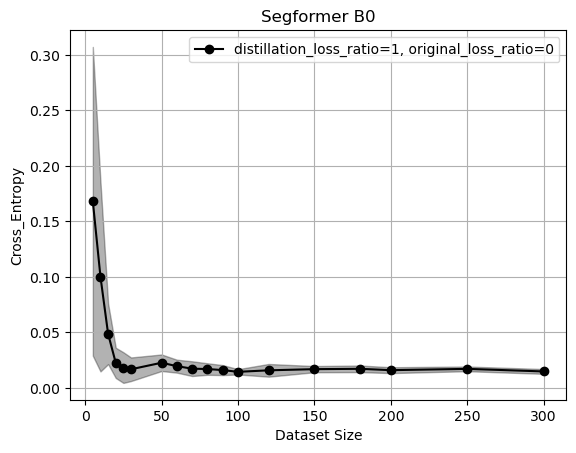

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0604')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.png"))

plt.show()